### Semantic Similarity Analysis

In [146]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from collections import defaultdict
from tqdm import tqdm
import json
import pandas as pd

In [84]:
dataset = "copyVSFactDomain"
model_name = "gpt2"
SAVE_FOLDER = f"../results/{dataset}/semantic_similarity/{model_name}_full"

if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [3]:
# gpt2 inference
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)
# tokenizer.pad_token_id = tokenizer.eos_token_id

In [4]:
# Load MiniLM model for similarity
minilm_model = SentenceTransformer('all-MiniLM-L6-v2')

In [9]:
with open("../data/full_data_sampled_gpt2_with_subjects.json", "r") as f:
    dataset = json.load(f)

target_new = [row["target_new"].strip() for row in dataset]

with open("../data/full_data_sampled_gpt2_with_domains.json", "r") as f:
    domain_dataset = json.load(f)

domain_target_new = [row["target_new"].strip() for row in dataset]

In [201]:
def inference(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt")
    model_outputs = model.generate(**inputs, 
                                   max_new_tokens=1, 
                                   return_dict_in_generate=True, output_scores=True, 
                                   pad_token_id=tokenizer.eos_token_id)
    generated_tokens_ids = model_outputs.sequences[0]
    generation = tokenizer.decode(generated_tokens_ids)
    attribute = tokenizer.decode(generated_tokens_ids[-1])

    return generation, attribute

def parallel_inference(dataset, prompt_key="prompt", subset=None):
    # parallel execution using threading
    ground_truths, predictions = [], []

    def process_row(row):
        ground_truth = row["target_true"].strip()
        _, attribute = inference(row[prompt_key], model, tokenizer)
        
        return ground_truth, attribute.strip()

    # Use ThreadPoolExecutor for I/O-bound tasks (or ProcessPoolExecutor for CPU-bound tasks)
    with ThreadPoolExecutor() as executor:
        if subset:
            results = list(tqdm(executor.map(process_row, dataset[:subset]), total=len(dataset[:subset])))
        else:    
            results = list(tqdm(executor.map(process_row, dataset), total=len(dataset)))

    ground_truths, predictions = zip(*results)

    return ground_truths, predictions

# Function to compute similarity between two texts using MiniLM
def compute_similarity_single(text1, text2):
    embeddings1 = minilm_model.encode(text1)
    embeddings2 = minilm_model.encode(text2)
    
    return cosine_similarity(embeddings1, embeddings2)[0][0]

def compute_similarity(dataset, key_1, key_2):
    outputs = []
    for row in tqdm(dataset):
        output = {
            key_1: row[key_1].strip(),
            key_2: row[key_2].strip(),
            "base_prompt": row["base_prompt"],
            "domain": row["domain"],
            "subject": row["subject"],
        }
        similarity = compute_similarity_single([row[key_1].strip()], [row[key_2].strip()])
        output["similarity"] = similarity
        outputs.append(output)

    return outputs

In [202]:
# key_1 = "base_prompt"
# key_1 = "subject"
key_1 = "target_new"
# key_2 = "target_new"
key_2 = "target_true"
outputs = compute_similarity(domain_dataset, key_1, key_2)

100%|██████████| 10000/10000 [02:26<00:00, 68.47it/s]


In [203]:
output_df = pd.DataFrame(outputs)
output_df["domain"] = [row["domain"] for row in domain_dataset]
output_df["target_new"] = [row["target_new"].strip() for row in domain_dataset]
output_df["target_true"] = [row["target_true"].strip() for row in domain_dataset]
output_df.to_csv(f"{SAVE_FOLDER}/cosine_similarity_{key_1}_{key_2}.csv", index=False)

In [204]:
output_df.groupby("domain")["similarity"].mean()

domain
Arts_and_Entertainment       0.539503
Autos_and_Vehicles           0.504377
Books_and_Literature         0.467548
Business_and_Industrial      0.507882
Computers_and_Electronics    0.388517
Finance                      0.436399
Food_and_Drink               0.522299
Games                        0.433791
Health                       0.454408
Hobbies_and_Leisure          0.538954
Home_and_Garden              0.434675
Internet_and_Telecom         0.383026
Jobs_and_Education           0.532020
Law_and_Government           0.521425
News                         0.510351
Online_Communities           0.322059
People_and_Society           0.516768
Real_Estate                  0.615594
Science                      0.449623
Sensitive_Subjects           0.467847
Shopping                     0.372567
Sports                       0.573698
Travel_and_Transportation    0.496867
Name: similarity, dtype: float32

In [122]:
def plot_factual_accuracy_by_domain(dataframe, similarity_col, domain_col, bins=10):
    """
    Plot factual accuracy vs similarity for each domain.
    
    Args:
        dataframe (pd.DataFrame): Input dataframe with similarity and domain columns.
        similarity_col (str): The column name for similarity scores.
        domain_col (str): The column name for domain.
        bins (int): Number of bins to split similarity scores.
    
    Returns:
        None
    """
    # Create bins for similarity scores
    bins_edges = np.linspace(0, 1, bins + 1)
    dataframe['similarity_bin'] = pd.cut(dataframe[similarity_col], bins=bins_edges, labels=bins_edges[:-1])

    # Initialize plot
    plt.figure(figsize=(14, 8))
    
    # Group by domain
    for domain, domain_data in dataframe.groupby(domain_col):
        # Calculate factual accuracy (count of rows per bin / total)
        bin_counts = domain_data['similarity_bin'].value_counts(normalize=False, sort=False)
        
        # Plot the distribution
        plt.plot(bin_counts.index.astype(float), bin_counts.values, marker='o', label=domain)
    
    # Customizing the plot
    plt.title("Base Prompt and Target True Similarity")
    plt.xlabel("Similarity Bins")
    plt.ylabel("Frequency")
    plt.legend(title="Domain", loc="upper right")
    plt.grid(True)
    plt.show()

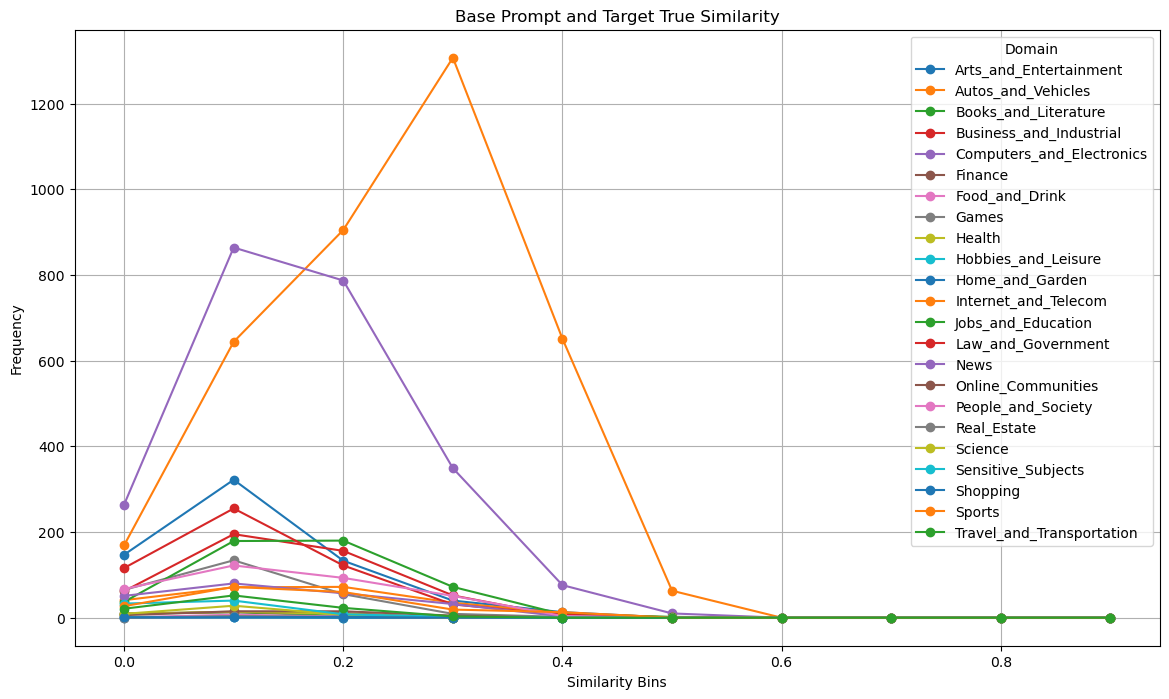

In [ ]:
plot_factual_accuracy_by_domain(output_df.copy(), similarity_col="similarity", domain_col="domain", bins=10)

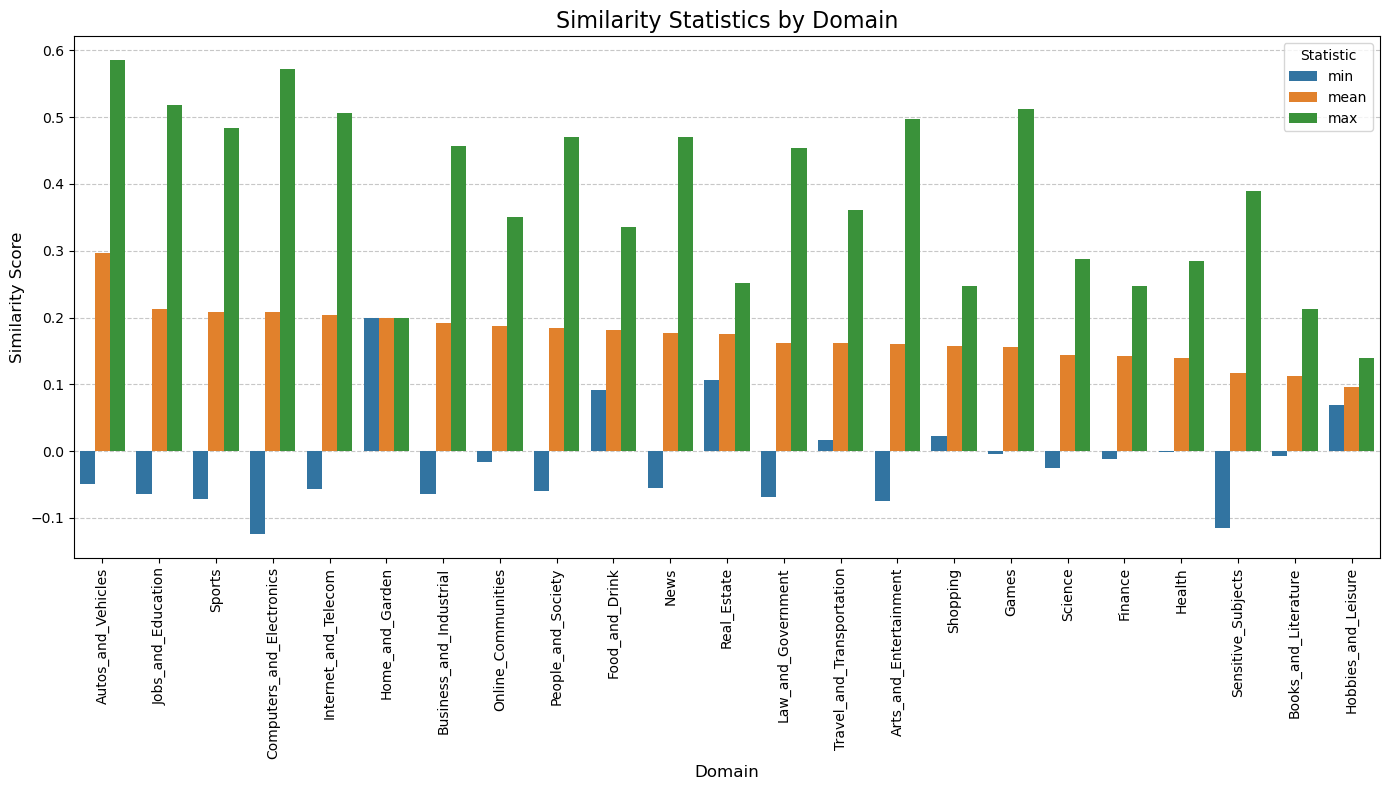

In [ ]:
def plot_similarity_stats_by_domain(dataframe, similarity_col, domain_col):
    """
    Plot min, mean, and max similarity scores grouped by domain.
    
    Args:
        dataframe (pd.DataFrame): Input dataframe with similarity and domain columns.
        similarity_col (str): The column name for similarity scores.
        domain_col (str): The column name for domain.
    
    Returns:
        None
    """
    # Group data by domain and calculate min, mean, max
    stats = dataframe.groupby(domain_col)[similarity_col].agg(['min', 'mean', 'max']).sort_values(by='mean', ascending=False).reset_index()

    # Melt the dataframe for Seaborn compatibility
    stats_melted = stats.melt(id_vars=domain_col, value_vars=['min', 'mean', 'max'], 
                              var_name='Statistic', value_name='Similarity')

    # Initialize the Seaborn bar plot
    plt.figure(figsize=(14, 8))
    sns.barplot(data=stats_melted, x=domain_col, y='Similarity', hue='Statistic')

    # Customizing the plot
    plt.title("Similarity Statistics by Domain", fontsize=16)
    plt.xlabel("Domain", fontsize=12)
    plt.ylabel("Similarity Score", fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.legend(title="Statistic", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.gca().set_axisbelow(True)
    plt.show()

plot_similarity_stats_by_domain(output_df.copy(), similarity_col="similarity", domain_col="domain")

In [140]:
ground_truths, predictions = parallel_inference(domain_dataset, prompt_key="prompt", subset=None)

100%|██████████| 10000/10000 [02:48<00:00, 59.28it/s]


In [205]:
output_df["target_true"] = ground_truths
output_df["prediction"] = predictions
output_df["target_new"] = output_df["target_new"].str.strip()
output_df.to_csv(f"{SAVE_FOLDER}/cosine_similarity_{key_1}_{key_2}.csv", index=False)

In [178]:
(accuracy_score(output_df["target_true"], output_df["prediction"]))*100

4.130000000000001

In [198]:
def plot_factual_frequency_by_similarity(dataframe, similarity_col, target_true_col, prediction_col, bins=10):
    """
    Plot the prediction frequency of factual tokens by similarity level.
    
    Args:
        dataframe (pd.DataFrame): Input dataframe with similarity, target_true, and prediction columns.
        similarity_col (str): The column name for similarity scores.
        target_true_col (str): The column name for the true target tokens.
        prediction_col (str): The column name for model predictions.
        bins (int): Number of bins for similarity scores.
    
    Returns:
        None
    """
    # Create bins for similarity scores
    bins_edges = np.linspace(0, 1, bins + 1)
    bin_labels = [f"{int(x*100)}-{int((x+0.1)*100)}%" for x in bins_edges[:-1]]  # Label bins as percentages
    dataframe['similarity_bin'] = pd.cut(dataframe[similarity_col], bins=bins_edges, labels=bin_labels)
    print(dataframe['similarity_bin'].value_counts())

    # Calculate the percentage of factual predictions for each bin
    bin_stats = dataframe.groupby('similarity_bin').apply(
        lambda df: (df[prediction_col] == df[target_true_col]).mean() * 100  # Convert to percentage
    ).reset_index(name='factual_percentage')

    # Overall factual percentage
    overall_factual_percentage = (dataframe[prediction_col] == dataframe[target_true_col]).mean() * 100  # Overall percentage

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=bin_stats, x='similarity_bin', y='factual_percentage', marker='o', label='Factual % by bin')
    plt.axhline(y=overall_factual_percentage, color='r', linestyle='--', label='Overall Factual %')

    # Customizing the plot
    plt.title("Prediction Frequency of Factual Token by Similarity Level", fontsize=16)
    plt.xlabel("Similarity Bins (%)", fontsize=12)
    plt.ylabel("Factual Prediction Percentage (%)", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

similarity_bin
20-30%     2734
10-20%     2610
30-40%     1713
40-50%     1464
0-10%       831
50-60%      535
60-70%       37
70-80%        1
80-90%        0
90-100%       0
Name: count, dtype: int64


/var/folders/td/y5rm_6ss32l0032fg78j9xgc0000gn/T/ipykernel_154/3576266765.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = dataframe.groupby('similarity_bin').apply(


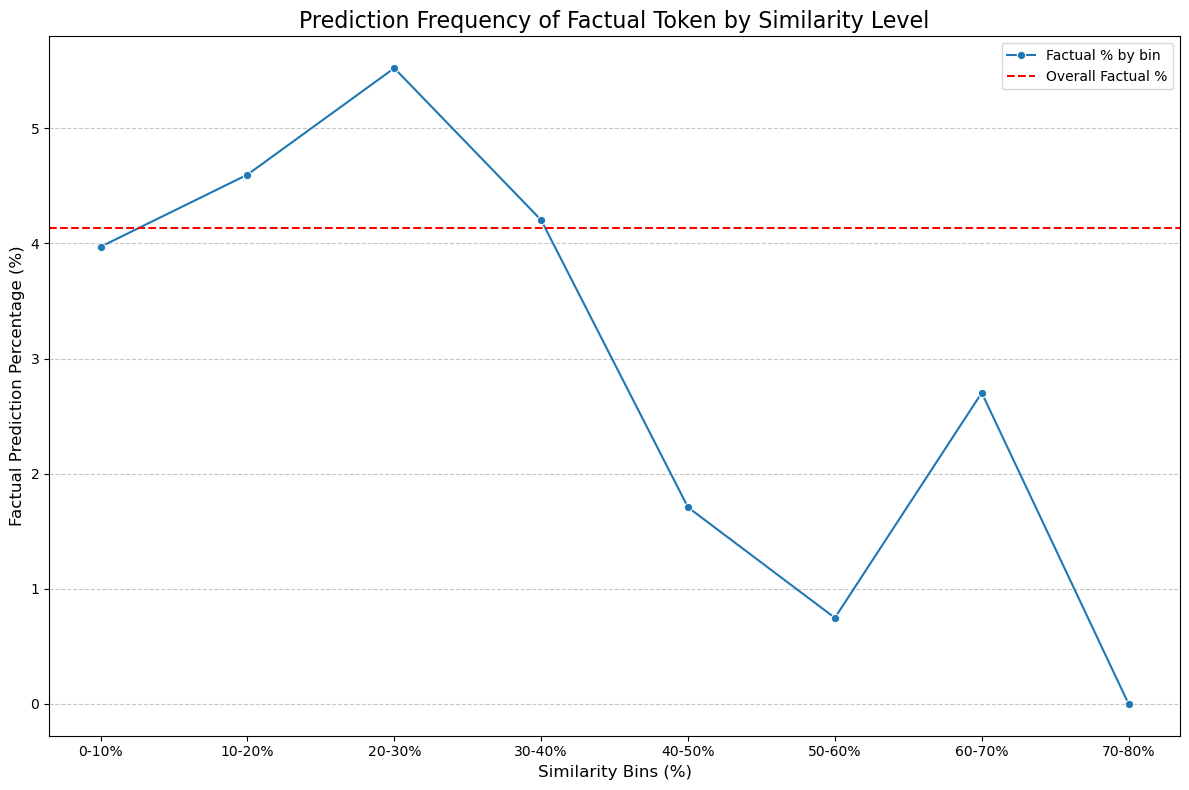

In [199]:
# Example usage
plot_factual_frequency_by_similarity(
    output_df.copy(),
    similarity_col="similarity",
    target_true_col="target_true",
    prediction_col="prediction",
    bins=10
)

similarity_bin
70-80%     2223
50-60%     1635
60-70%     1581
40-50%     1307
30-40%     1162
80-90%     1041
20-30%      827
10-20%      128
90-100%      52
0-10%        20
Name: count, dtype: int64


/var/folders/td/y5rm_6ss32l0032fg78j9xgc0000gn/T/ipykernel_154/3576266765.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = dataframe.groupby('similarity_bin').apply(


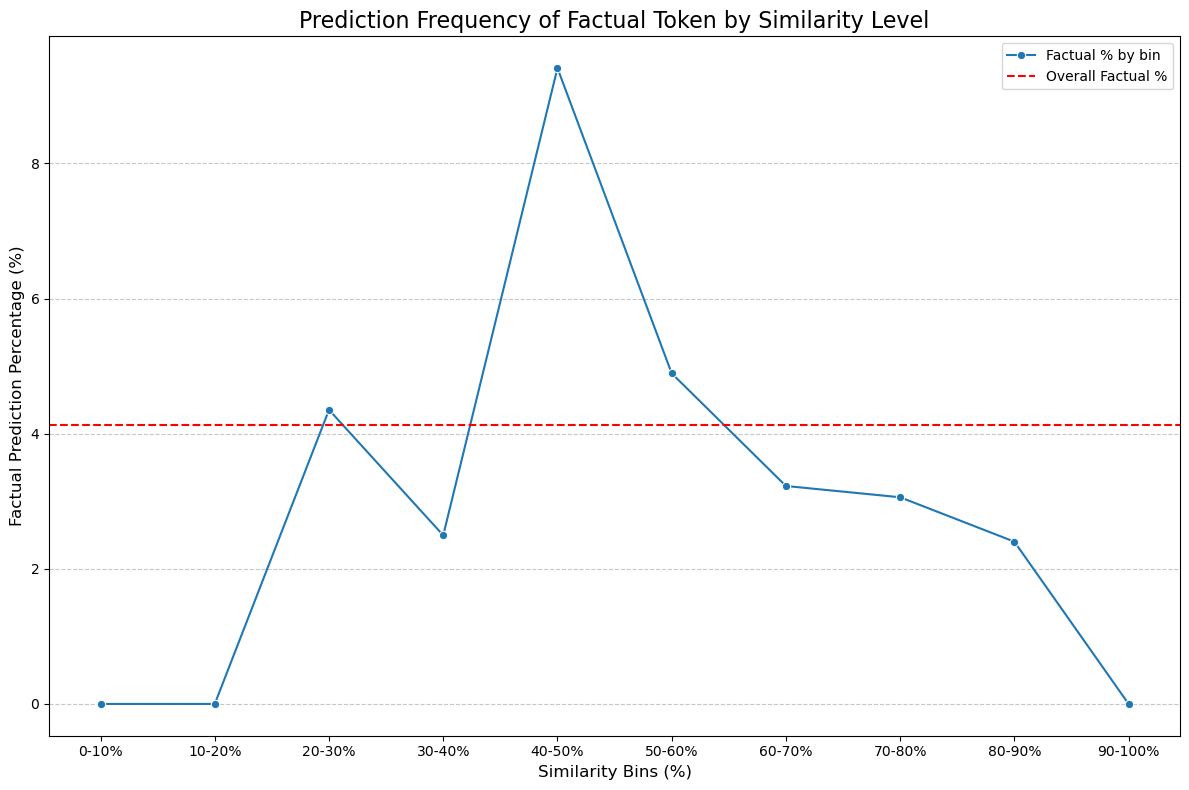

In [193]:
# Example usage
plot_factual_frequency_by_similarity(
    output_df.copy(),
    similarity_col="similarity",
    target_true_col="target_true",
    prediction_col="prediction",
    bins=10
)

/var/folders/td/y5rm_6ss32l0032fg78j9xgc0000gn/T/ipykernel_154/3576266765.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = dataframe.groupby('similarity_bin').apply(


similarity_bin
50-60%     2663
30-40%     2034
40-50%     1986
60-70%     1871
20-30%     1068
70-80%      243
10-20%      101
0-10%        28
80-90%        6
90-100%       0
Name: count, dtype: int64


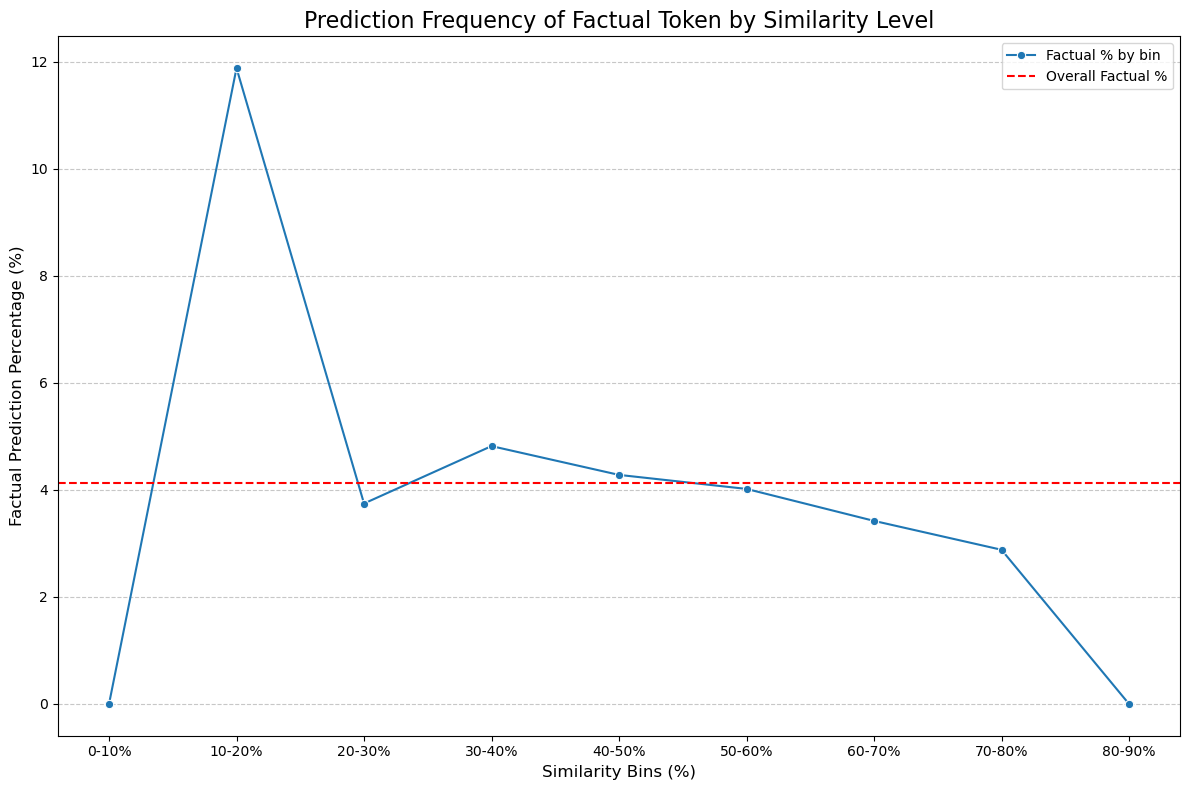

In [206]:
# Example usage
plot_factual_frequency_by_similarity(
    output_df.copy(),
    similarity_col="similarity",
    target_true_col="target_true",
    prediction_col="prediction",
    bins=10
)